In [1]:
import pandas as pd 

# List of all 41 feature column names from NSL-KDD, plus the 'label' column
column_names = [
    "duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent",
    "hot","num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds","is_host_login",
    "is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate",
    "same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label", "difficulty"
]

In [2]:
# Load training and test datasets from the data folder
train_path = "../data/KDDTrain+.txt"
test_path = "../data/KDDTest+.txt"

df_train = pd.read_csv(train_path, names=column_names, header=None)
df_test = pd.read_csv(test_path, names=column_names, header=None)

# Print the shape of both datasets to confirm successful loading
print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)
df_train.head()

Train shape: (125973, 43)
Test shape: (22544, 43)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [3]:
# Step 1: Convert the original 'label' column into a binary label:
#   - 0 for 'normal' (non-attack)
#   - 1 for anything else (attack)

df_train["label_binary"] = df_train["label"].apply(lambda x: 0 if x == "normal" else 1)
df_test["label_binary"] = df_test["label"].apply(lambda x: 0 if x == "normal" else 1)


In [4]:
# Check how many normal vs attack records are in each dataset
# Helps us understand class imbalance

print("Training set lavel breakdown:")
print(df_train["label_binary"].value_counts())

print("Test set label breakdown:")
print(df_test["label_binary"].value_counts())


Training set lavel breakdown:
label_binary
0    67343
1    58630
Name: count, dtype: int64
Test set label breakdown:
label_binary
1    12833
0     9711
Name: count, dtype: int64


In [5]:
# Step 2: One-hot encode categorical features

# These are the categorical columns in the dataset
categorical_cols = ["protocol_type", "service", "flag"]

# One-hot encode both train and test sets
df_train_encoded = pd.get_dummies(df_train, columns=categorical_cols)
df_test_encoded = pd.get_dummies(df_test, columns=categorical_cols)

# Ensure train and test sets have the same columns (align them)
df_train_encoded, df_test_encoded = df_train_encoded.align(
    df_test_encoded,
    join="left",
    axis=1,
    fill_value=0
)

# Sanity check
print("One-hot encoded train shape:", df_train_encoded.shape)
print("One-hot encoded test shape:", df_test_encoded.shape)
print(df_train_encoded.columns.tolist())

One-hot encoded train shape: (125973, 125)
One-hot encoded test shape: (22544, 125)
['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'difficulty', 'label_binary', 'protocol_type_icmp', 'protocol_type_tcp', 'protocol_type_udp', 'service_IRC', 'service_X11', 'service_Z39_50', 'service_aol', 'service_auth', 'service_bgp', 'service_courier', 'servic

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


# Step 3: Prepare features and labels 
x_train = df_train_encoded.drop(columns=["label", "label_binary", "difficulty"])
y_train = df_train_encoded["label_binary"]

x_test = df_test_encoded.drop(columns=["label", "label_binary", "difficulty"])
y_test = df_test_encoded["label_binary"]

# ------------------------------------------------------
# Step 4: Create and train a Random Forest Model
# ------------------------------------------------------ 

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(x_train, y_train)

# Predict on the test set
y_pred = model.predict(x_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7650372604684174
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.97      0.78      9711
           1       0.97      0.61      0.75     12833

    accuracy                           0.77     22544
   macro avg       0.81      0.79      0.76     22544
weighted avg       0.83      0.77      0.76     22544



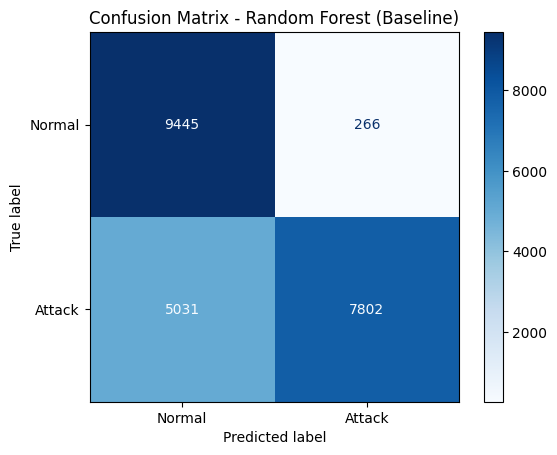

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Display the matrix with matplotlib
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Attack"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest (Baseline)")
plt.show()

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Step 4.2: Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'class_weight': ['balanced']
}

# Initialize the base model
rf = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,                         # 3-fold cross-validation
    scoring='f1',                 # optimize for f1-score (balances precision & recall)
    verbose=2,
    n_jobs=-1                     # use all CPU cores
)

# Run the grid search
grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [10, 15, 20],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 150]},
             scoring='f1', verbose=2)

In [13]:
# Best model
best_model = grid_search.best_estimator_

# Predict
y_pred_best = best_model.predict(x_test)

# Evaluate
print("Best Params:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("Classification Report:\n", classification_report(y_test, y_pred_best))


Best Params: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Accuracy: 0.782735982966643
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.97      0.79      9711
           1       0.97      0.64      0.77     12833

    accuracy                           0.78     22544
   macro avg       0.82      0.81      0.78     22544
weighted avg       0.84      0.78      0.78     22544



### Random Forest Hyperparameter Tuning Attempts

Several combinations of hyperparameters were tested using GridSearchCV with different objectives:

- Initial tuning used `scoring='f1'` to balance precision and recall.
  - Tried: `n_estimators=[100, 150]`, `max_depth=[10, 15, 20]`, etc.
  - Best recall: ~64%

- Second tuning focused on maximizing **recall** with `scoring='recall'`.
  - Increased `max_depth` to 25
  - Recall dropped slightly to ~62%, suggesting the model reached its limit.

These experiments led to the decision to explore other models such as Logistic Regression and XGBoost.

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# ------------------------------------------------------
# Step 5: Create and train Logistic Regression Model
# ------------------------------------------------------ 

#  Initialize Logistic Regression with class_weight balanced
log_reg = LogisticRegression(
    class_weight='balanced',     # tells it to handle imbalance automatically
    max_iter=2000,               # allow more iterations to ensure convergence
    solver='saga',
    tol=0.01,                    # relax tolerance to prevdoes ent logistic regression from flagging warning that convergence has not occured
    random_state=42
)

# Train the model
log_reg.fit(x_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42,
                   solver='saga', tol=0.01)

Logistic Regression Accuracy: 0.544402058197303
Classification Report:
               precision    recall  f1-score   support

           0       0.01      0.00      0.00      9711
           1       0.56      0.96      0.70     12833

    accuracy                           0.54     22544
   macro avg       0.28      0.48      0.35     22544
weighted avg       0.32      0.54      0.40     22544



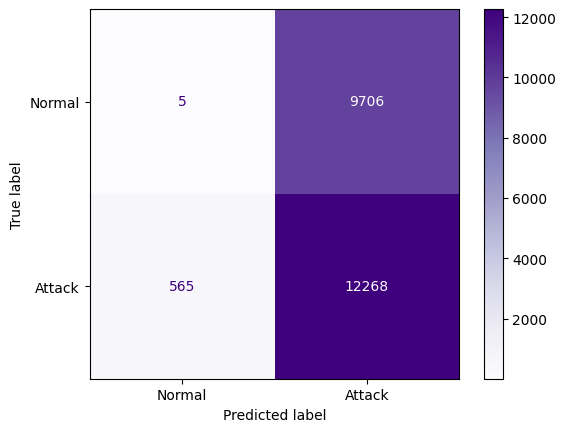

In [29]:
# Predict on test data and evaluate performance
y_pred_lr = log_reg.predict(x_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

# Display Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lr, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Attack"])
disp.plot(cmap="Purples")